### Relative geolocation error in random points

In [1]:
import numpy as np
import pandas as pd
import itertools

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 18})

from osgeo import gdal

import isce
import isceobj
from mroipac.ampcor.Ampcor import Ampcor
from isceobj.Orbit.Orbit import Orbit, StateVector

This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce


In [2]:
def loadProduct(xmlname):
        '''
        Load the product using Product Manager.
        '''

        from iscesys.Component.ProductManager import ProductManager as PM

        pm = PM()
        pm.configure()

        obj = pm.loadProduct(xmlname)

        return obj

#### Reading reference and secondary SLC files

In [3]:
#reading SLC file
refSLCvrt = './datasets/20210106.slc.full.vrt'
secSLCvrt = './datasets/20210118.slc.full.vrt'

refds = gdal.Open(refSLCvrt, gdal.GA_ReadOnly)
refslc = refds.GetRasterBand(1).ReadAsArray()
refds = None

secds = gdal.Open(secSLCvrt, gdal.GA_ReadOnly)
secslc = secds.GetRasterBand(1).ReadAsArray()
secds = None

xmlfile = './datasets/IW2.xml'
info = loadProduct(xmlfile)  #loading xml file

#reading orbit info from xml
orb = Orbit()  #Orbit class

for sv in info.orbit.stateVectors.list:
    
    SV = StateVector()
    
    SV.setTime(sv.getTime())
    SV.setPosition(sv.getPosition())
    SV.setVelocity(sv.getVelocity())
    
    orb.addStateVector(SV)

sensingStart = info.sensingStart
sensingMid = info.sensingMid
sensingStop = info.sensingStop

print(sensingStart,sensingMid,sensingStop)
    
orb.minTime = sensingStart
orb.maxTime = sensingStop
    
info = loadProduct(xmlfile)  #loading xml file
rangePixelSize = info.bursts.burst1.rangePixelSize
print('rangepixelsize (m): ',rangePixelSize)

nearRange = info.startingRange
midRange = info.midRange
farRange = info.farRange

print('range (m) (near, mid, far)',nearRange, midRange, farRange)

2021-01-06 13:52:29.060062 2021-01-06 13:52:31.990258 2021-01-06 13:52:34.920453
rangepixelsize (m):  2.329562114715323
range (m) (near, mid, far) 846067.2431679851 875603.7612204608 905140.2792729363


In [4]:
#calculating azimuth pixel spacing given satellite geometry
azimuthTimeInterval = info.bursts.burst1.azimuthTimeInterval   #line time interval
Vs = np.linalg.norm(orb.interpolateOrbit(info.sensingMid,method='hermite').getVelocity())  #satellite velocity at center
Ps = np.linalg.norm(orb.interpolateOrbit(info.sensingMid,method='hermite').getPosition())  #satellite position at center

#approximate terrain height 
terrainHeight = info.bursts.burst1.terrainHeight

#latitude, longitude, elevation at image center
llh = orb.rdr2geo(sensingMid,midRange,height=terrainHeight)

from isceobj.Planet.Planet import Planet
refElp = Planet(pname='Earth'). ellipsoid
xyz = refElp.llh_to_xyz(llh) #xyz coordinate at image center

Re = np.linalg.norm(xyz)
cosb = (Ps**2 + Re**2 - midRange**2)/(2*Ps*Re)
Vg = (Re*cosb)*Vs/Ps

print('satellite velocity (m/s)',Vs)
print('satellite velocity over the ground (m/s)',Vg)

azimuthPixelSize = Vg*azimuthTimeInterval
print('azimuthPixelSize (m): ',azimuthPixelSize)

satellite velocity (m/s) 7594.599145097766
satellite velocity over the ground (m/s) 6822.502433800593
azimuthPixelSize (m):  14.024037859564128


#### Finding random points from an image

In [5]:
refamp = np.abs(refslc)  
secamp = np.abs(secslc)

length, width = refamp.shape

#range of approximate valid pixels
minvalX = np.min(np.nonzero(refamp)[1])
maxvalX = np.max(np.nonzero(refamp)[1])
minvalY = np.min(np.nonzero(refamp)[0])
maxvalY = np.max(np.nonzero(refamp)[0])

In [6]:
#half window size
xhalfwin = 16
yhalfwin = 16

#selecting random points in x and y axis
randX = np.random.randint((minvalX+xhalfwin),(maxvalX-xhalfwin), 320)  
randY = np.random.randint((minvalY+yhalfwin),(maxvalY-yhalfwin), 200)

randXY = np.array(list(itertools.product(randX,randY)))
row, col = randXY.shape
randind = np.random.randint(0,row, 800)
randXY = randXY[randind,:]

xlocs = randXY[:,0]
ylocs = randXY[:,1]

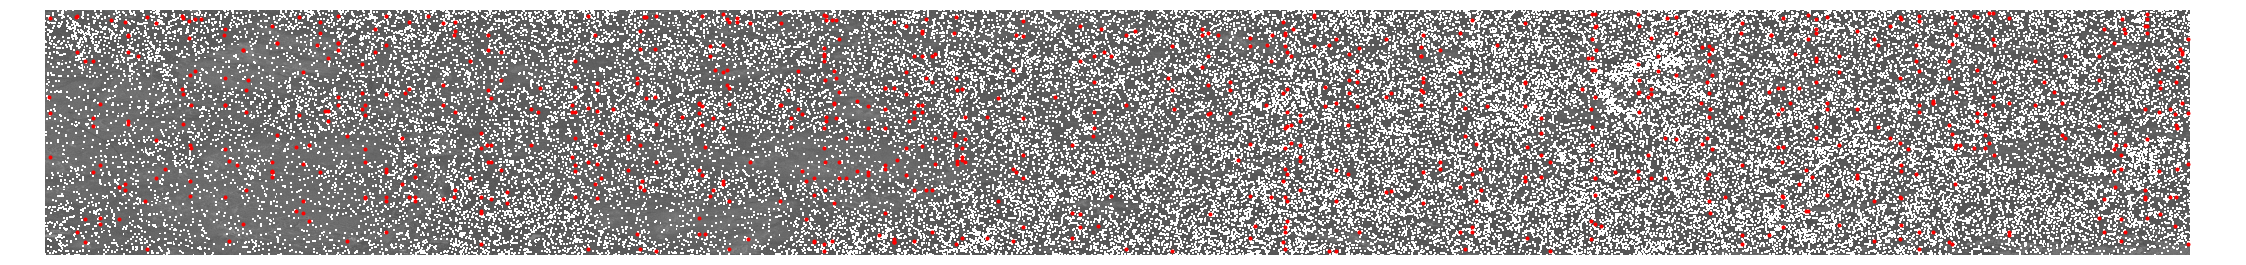

In [7]:
try:
    refslc[refslc==0]=np.nan
except:
    pass

ampdB = 20*np.log10(np.abs(refslc))

fig, ax = plt.subplots(figsize=(40, 10))
cax=ax.imshow(ampdB, cmap='gray',interpolation=None, origin='upper')
ax.plot(xlocs, ylocs, 'r.')
ax.axis('off')
ax.set_aspect(1)
fig.savefig('Rosamond_random_points.png',dpi=300,bbox_inches='tight')

#### Relative geolocation error in random points

In [ ]:
mean_dx = []
mean_dy = []
std_dx = []
std_dy = []
x_avail = []
y_avail = []
snr = []

for xoff, yoff in zip(xlocs, ylocs):
    
    #cropping amplitude image around selected points
    ampcrop_ref = refamp[(yoff-yhalfwin+1):(yoff+yhalfwin),(xoff-xhalfwin+1):(xoff+xhalfwin)]
    ampcrop_sec = secamp[(yoff-yhalfwin+1):(yoff+yhalfwin),(xoff-xhalfwin+1):(xoff+xhalfwin)]
    nonzero_ref = np.count_nonzero(ampcrop_ref)   #counting nonzero components in chip
    nonzero_sec = np.count_nonzero(ampcrop_sec)
    
    (chiplength, chipwidth) = ampcrop_ref.shape
    
    objAmpcor = Ampcor()
    objAmpcor.configure()
    objAmpcor.setImageDataType1('real')
    objAmpcor.setImageDataType2('real')
    objAmpcor.acrossGrossOffset = 0
    objAmpcor.downGrossOffset = 0
    
    objAmpcor.windowSizeWidth = 16
    objAmpcor.windowSizeHeight = 16
    objAmpcor.searchWindowSizeWidth = 8
    objAmpcor.searchWindowSizeHeight = 8
    objAmpcor.oversamplingFactor = 32
    
    #saving reference and secondary chips
    refimg = isceobj.Image.createImage()
    refimg.setFilename('ref.dat')
    refimg.setWidth(chipwidth)
    refimg.setLength(chiplength)
    refimg.setAccessMode('write')
    refimg.bands = 1
    DataType = 'FLOAT'
    outtype = '<f'
    refimg.dataType = DataType
    refimg.scheme = 'BIP'
    refimg.renderHdr()
    refimg.renderVRT()
    refimg.finalizeImage()
    
    fout = open('ref.dat', "wb")
    ampcrop_ref.astype(outtype).tofile(fout)   #little endian
    refimg = None
    
    secimg = isceobj.Image.createImage()
    secimg.setFilename('sec.dat')
    secimg.setWidth(chipwidth)
    secimg.setLength(chiplength)
    secimg.setAccessMode('write')
    secimg.bands = 1
    DataType = 'FLOAT'
    outtype = '<f'
    secimg.dataType = DataType
    secimg.scheme = 'BIP'
    secimg.renderHdr()
    secimg.renderVRT()
    secimg.finalizeImage()
    
    fout = open('sec.dat', "wb")
    ampcrop_sec.astype(outtype).tofile(fout)   #little endian
    secimg = None

    #loading saved chips 
    referenceImg = isceobj.createImage()   #Empty image
    referenceImg.load('./ref.dat.xml') #Load from XML file
    referenceImg.setAccessMode('read')     #Set it up for reading 
    referenceImg.createImage()             #Create File
    
    secondaryImg = isceobj.createImage()    #Empty image
    secondaryImg.load('./sec.dat.xml')   #Load it from XML file
    secondaryImg.setAccessMode('read')      #Set it up for reading
    secondaryImg.createImage()              #Create File
    
    #ampcor: amplitude cross-correlation
    objAmpcor.ampcor(referenceImg,secondaryImg)

    referenceImg.finalizeImage()
    secondaryImg.finalizeImage()
    referenceImg = None
    secondaryImg = None
    
    offField = objAmpcor.getOffsetField()
    field = np.array(offField.unpackOffsets())
    
    if (field.size != 0) and (nonzero_ref != 0) and (nonzero_sec != 0):
        dict = { 'x': field[:,0].astype(int), 'dx': field[:,1], \
                'y': field[:,2].astype(int), 'dy': field[:,3], 'SNR': field[:,4]}
        df = pd.DataFrame(dict)
        mean_dx.append(df['dx'].mean())
        mean_dy.append(df['dy'].mean())
        std_dx.append(df['dx'].std())
        std_dy.append(df['dy'].std())
        snr.append(df['SNR'].mean())
        x_avail.append(xoff)
        y_avail.append(yoff)
        df = None

In [9]:
#converting pixel to meter
mean_dx = [rangePixelSize*x for x in mean_dx]
mean_dy = [azimuthPixelSize*x for x in mean_dy]

std_dx = [rangePixelSize*x for x in std_dx]
std_dy = [azimuthPixelSize*x for x in std_dy]

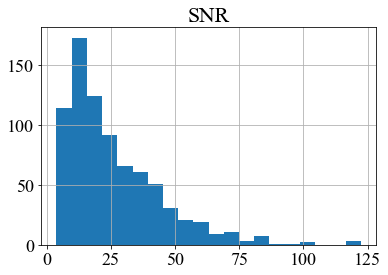

In [10]:
dict = {'x':x_avail,'y':y_avail,'mean_dx':np.abs(mean_dx),'std_dx':std_dx,\
        'mean_dy':np.abs(mean_dy),'std_dy':std_dy,'SNR':snr}
df = pd.DataFrame(dict)
df.hist(column='SNR',bins=20)
df_filter = df[(df['SNR']>60) & (df['mean_dx'] != 0.0) & (df['mean_dy'] != 0.0)]    #thresholding (choosing high SNR and non-zero offsets)
# df_filter = df[(df['SNR']>60)]    #thresholding 
df = None

x_avail = df_filter['x']
y_avail = df_filter['y']
mean_dx = df_filter['mean_dx']
mean_dy = df_filter['mean_dy']
std_dx = df_filter['std_dx']
std_dy = df_filter['std_dy']
snr = df_filter['SNR']

In [11]:
print('mean range offset (m): ',df_filter['mean_dx'].mean(),\
      '\nmean azimuth offset (m): ',df_filter['mean_dy'].mean())

mean range offset (m):  0.10139835097533215 
mean azimuth offset (m):  0.6542464090734158


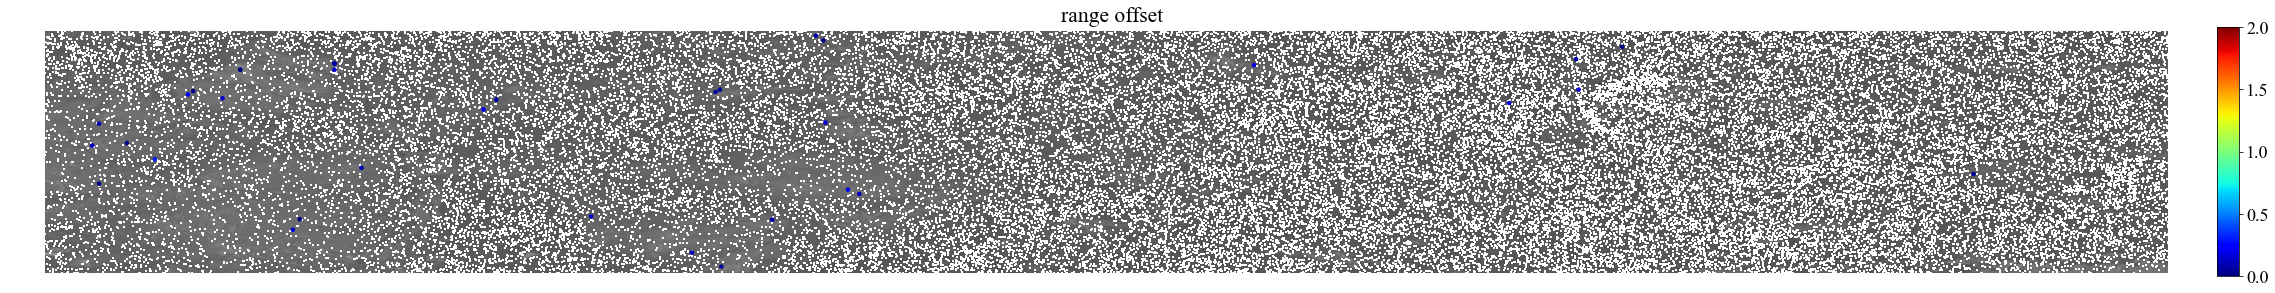

In [12]:
fig, ax = plt.subplots(figsize=(40, 10))
ax.imshow(ampdB, cmap='gray',interpolation=None, origin='upper')
im = ax.scatter(x_avail, y_avail, c=mean_dx, cmap='jet',vmin=0,vmax=2, marker='.',s=50)
ax.axis('off')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.01)
fig.colorbar(im,cax=cax)
ax.set_aspect(1)
ax.set_title('range offset')
fig.savefig('Rosamond_rnd_rngOffset.png',dpi=300,bbox_inches='tight')

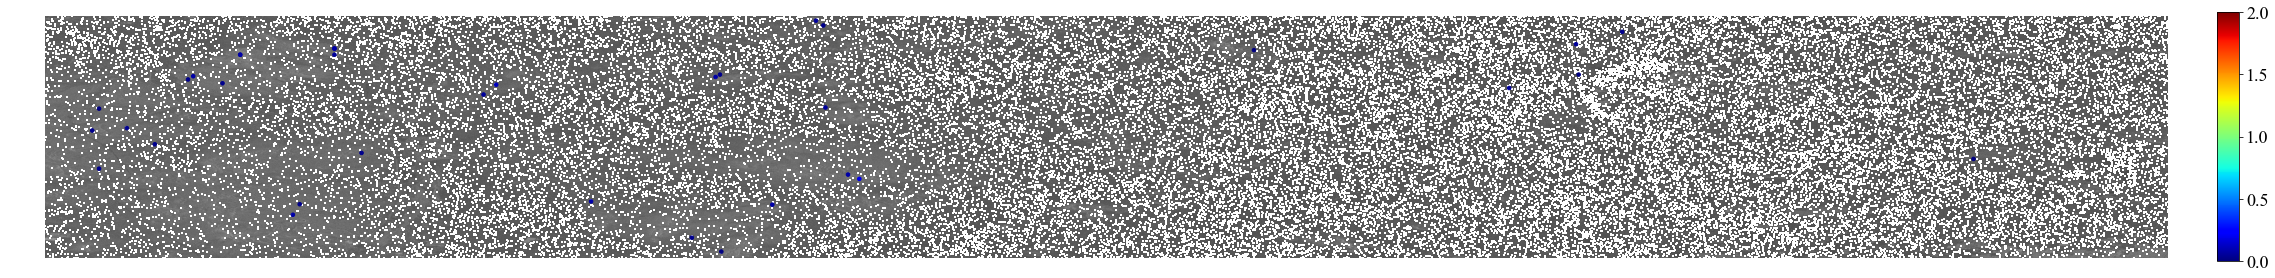

In [13]:
fig, ax = plt.subplots(figsize=(40, 10))
ax.imshow(ampdB, cmap='gray',interpolation=None, origin='upper')
im = ax.scatter(x_avail, y_avail, c=std_dx, cmap='jet',vmin=0,vmax=2, marker='.',s=50)
ax.axis('off')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.01)
fig.colorbar(im,cax=cax)
ax.set_aspect(1)
fig.savefig('Rosamond_rnd_rngOffset_std.png',dpi=300,bbox_inches='tight')

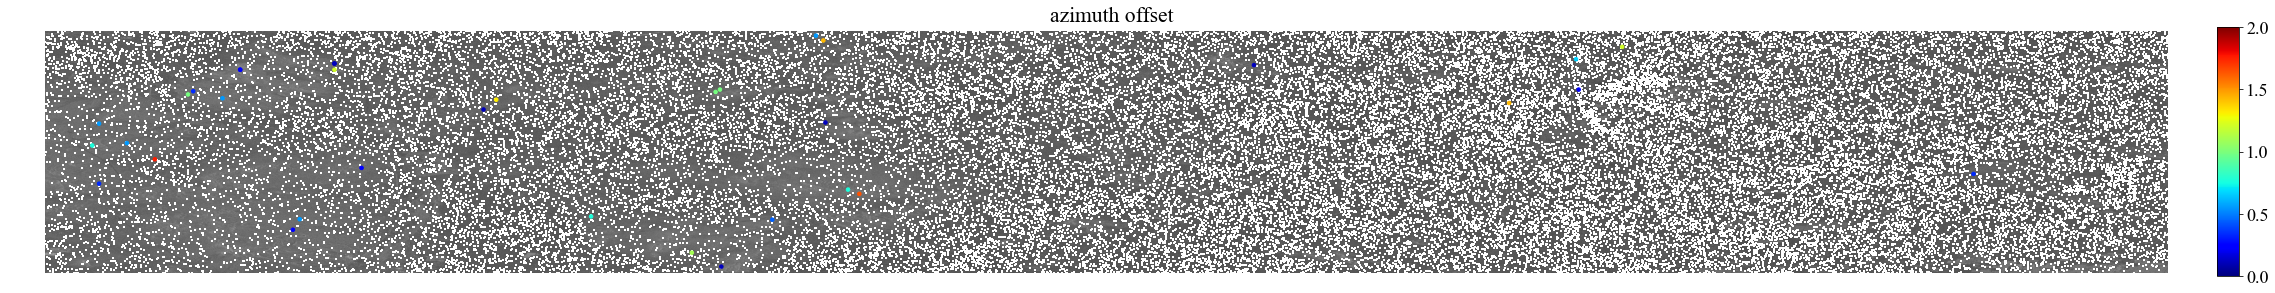

In [14]:
fig, ax = plt.subplots(figsize=(40, 10))
ax.imshow(ampdB, cmap='gray',interpolation=None, origin='upper')
im = ax.scatter(x_avail, y_avail, c=mean_dy, cmap='jet',vmin=0,vmax=2, marker='.',s=50)
ax.axis('off')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.01)
fig.colorbar(im,cax=cax)
ax.set_aspect(1)
ax.set_title('azimuth offset')
fig.savefig('Rosamond_rnd_azOffset.png',dpi=300,bbox_inches='tight')

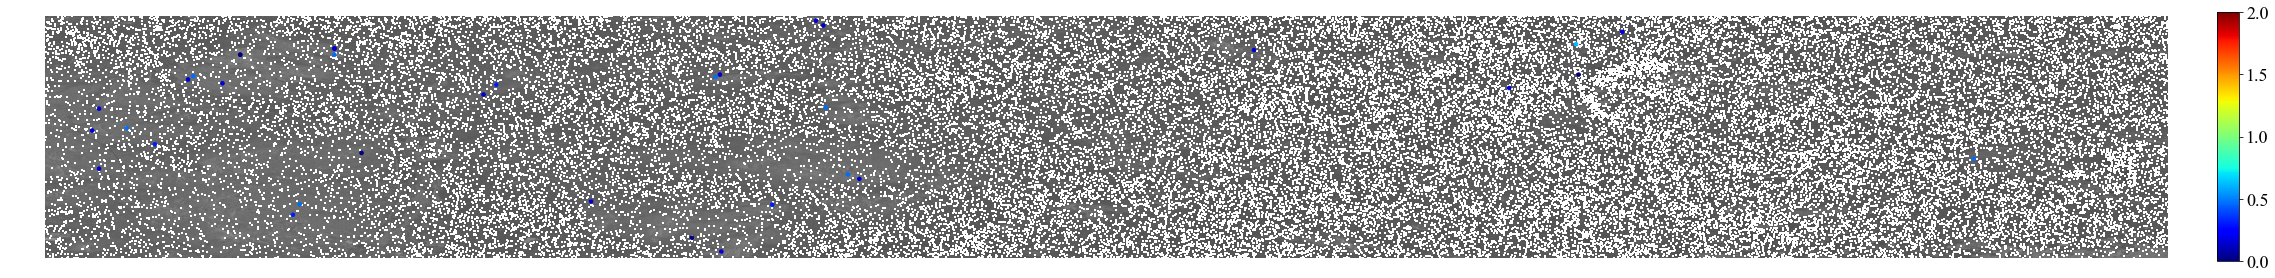

In [15]:
fig, ax = plt.subplots(figsize=(40, 10))
ax.imshow(ampdB, cmap='gray',interpolation=None, origin='upper')
im = ax.scatter(x_avail, y_avail, c=std_dy, cmap='jet',vmin=0,vmax=2, marker='.',s=50)
ax.axis('off')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.01)
fig.colorbar(im,cax=cax)
ax.set_aspect(1)
fig.savefig('Rosamond_rnd_azOffset_std.png',dpi=300,bbox_inches='tight')

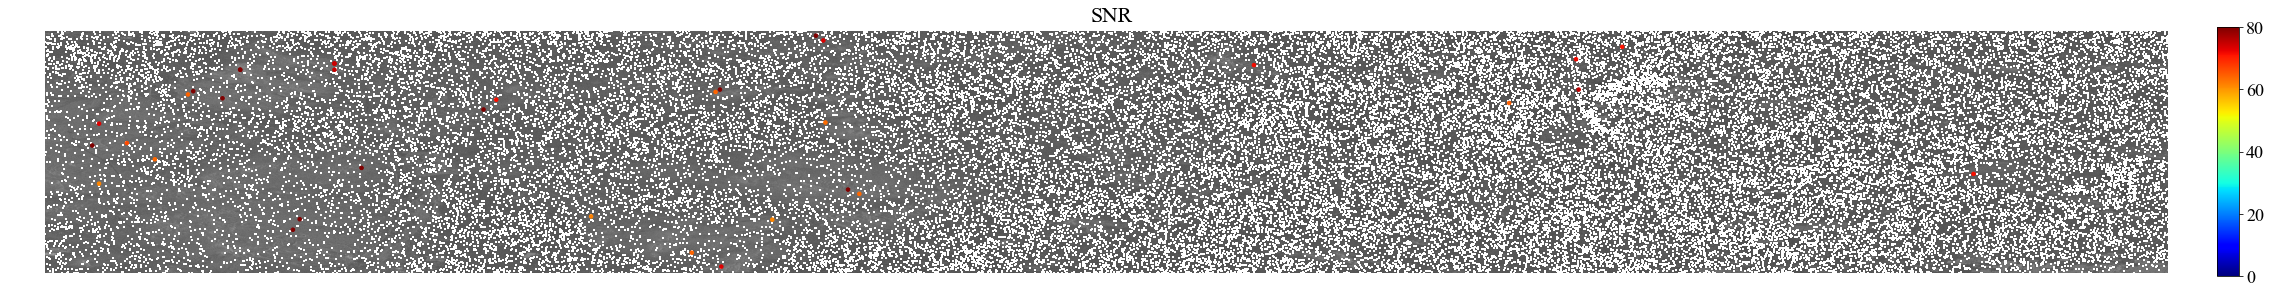

In [16]:
fig, ax = plt.subplots(figsize=(40, 10))
ax.imshow(ampdB, cmap='gray',interpolation=None, origin='upper')
im = ax.scatter(x_avail, y_avail, c=snr, cmap='jet',vmin=0,vmax=80, marker='.',s=50)
ax.axis('off')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.01)
fig.colorbar(im,cax=cax)
ax.set_aspect(1)
ax.set_title('SNR')
fig.savefig('Rosamond_rnd_snr.png',dpi=300,bbox_inches='tight')